<a href="https://colab.research.google.com/github/morimoto-aki/bass_AI/blob/main/bass_overlap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display 
from scipy import hamming


In [3]:
!wget https://github.com/morimoto-aki/bass_AI/raw/main/output/basscut1.wav

--2021-06-28 19:33:03--  https://github.com/morimoto-aki/bass_AI/raw/main/output/basscut1.wav
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/morimoto-aki/bass_AI/main/output/basscut1.wav [following]
--2021-06-28 19:33:04--  https://raw.githubusercontent.com/morimoto-aki/bass_AI/main/output/basscut1.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 922308 (901K) [audio/wav]
Saving to: ‘basscut1.wav’

basscut1.wav        100%[===================>] 900.69K  --.-KB/s    in 0.01s   

2021-06-28 19:33:04 (75.0 MB/s) - ‘basscut1.wav’ saved [922308/922308]



In [4]:
def FFT(x):
    N = x.shape[0]
    
    # 再起動作の一番最後
    if N==1:
        return x[0]
    
    x_even = x[0:N:2]
    x_odd = x[1:N:2]
    
    # ここで再帰動作をする
    X_even = FFT(x_even)
    X_odd = FFT(x_odd)
    
    # DFTと同じようにWを求める
    W = []
    for t in range(N//2):
        W.append(np.exp(-1j * ((2*np.pi*t) / N)))
    W = np.array(W)
    
    # ここで型をcomplexに指定しないとエラーを吐くので注意
    X = np.zeros(N, dtype="complex")
    X[0:N//2] = X_even + W*X_odd
    X[N//2:N] = X_even - W*X_odd
    
    return X

In [5]:
def STFT(x, win_length, hop=0.5):
    '''
    今回はwin=Mとして実装。
    データサイズも簡単のため2のべき乗に制限。
    hopはデフォルトで窓幅の半分とする。
    '''
    hop_length = int(win_length * hop)
    
    # 窓関数をかける時に端点が問題になります。
    # 今回はlibrosaのデフォルトに習って反転パディングをしてみます。
    pad_first = x[:hop_length]
    pad_last = x[-hop_length:][::-1]
    x_pad = np.concatenate([pad_first, x, pad_last])

    # データのサンプル数
    N = x_pad.shape[0]

    # FFTの結果を半分にした長さ
    M = int(win_length//2) + 1

    # 窓関数を適用する回数
    T = int((N - hop_length)/hop_length)

    # 今回はハミング窓（ハン窓）を利用します
    han = hamming(win_length)
    
    # 結果を格納する箱です
    spec = np.zeros((M,T), dtype="complex")
    
    for t in range(T):
        # まず窓関数を適用します
        windowed_x = x_pad[t*hop_length:t*hop_length+win_length] * han
        
        # 次にFFTを実行します。
        spec[:,t] = FFT(windowed_x)[:int(win_length//2)+1]
    return spec

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.hamming is deprecated and will be removed in SciPy 2.0.0, use numpy.hamming instead


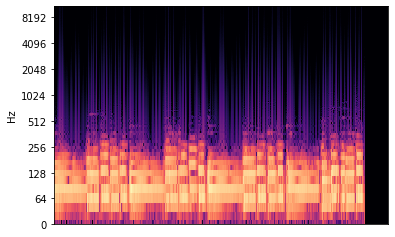

In [6]:
y, sr = librosa.load("basscut1.wav")
spec = STFT(y, 1024, 0.5)
spec_db = librosa.amplitude_to_db(np.abs(spec))
librosa.display.specshow(spec_db, y_axis="log")